# 结果可视化

In [6]:
import seaborn as sns
import multiprocessing as mp
import pandas as pd
import tqdm
import time
import copy
import numpy as np
#import MySQLdb
import os
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pickle
def save_variable(v,filename):
    f=open(filename,'wb')          #打开或创建名叫filename的文档。
    pickle.dump(v,f)               #在文件filename中写入v
    f.close()                      #关闭文件，释放内存。
    return filename

def load_variable(filename):
    try:
        f=open(filename,'rb')
        r=pickle.load(f)
        f.close()
        return r
    except EOFError:
        return ""

pickle_path='/Users/jason/JC/公告数据/'
#Factor_total_dict = load_variable(pickle_path+'Factors')
path = '/Users/jason/Desktop/科研/论文代码以及数据/公告类数据/'
Index_ret = load_variable(path+'index_return')

signal_df = load_variable(path+'signal_df')
twap_ret = load_variable(path + 'theoretical_rtn_metric')
twap_ret.index = [int(i) for i in twap_ret.index]
twap_ret.columns = [int(i) for i in twap_ret.columns]
real_ret = twap_ret[signal_df.columns]*signal_df

In [7]:
OLS_dict = load_variable(pickle_path+'OLS_dict')
PCA_dict = load_variable(pickle_path+'PCA_dict')
SVM_dict = load_variable(pickle_path+'SVM_dict')
KNN_dict = load_variable(pickle_path+'KNN_dict')
EN_dict = load_variable(pickle_path+'EN_dict')
XGB_dict = load_variable(pickle_path+'XGB_dict')
RF_dict = load_variable(pickle_path+'RF_dict')
EW_dict = load_variable(pickle_path+'EW_dict')
LSTM_dict = load_variable(pickle_path+'LSTM_dict')

In [8]:
Model_dict = {'OLS':OLS_dict,'PCA':PCA_dict,'SVM':SVM_dict,'KNN':KNN_dict,
                'EN':EN_dict,'XGB':XGB_dict,'RF':RF_dict,'EW':EW_dict,'LSTM':LSTM_dict}

In [ ]:
#ann_dict = load_variable(pickle_path+'ann_dict')

In [515]:
ann_dict['chg_pub'][20180102].dropna().index

Int64Index([     8,    415,    599,    687,    863,    890,   1696,   2007,
              2065,   2073,   2076,   2146,   2229,   2239,   2316,   2340,
              2342,   2390,   2406,   2452,   2581,   2606,   2756, 300048,
            300096, 300197, 300217, 300270, 300272, 300339, 300344, 300376,
            300387, 300426, 300445, 300470, 300529, 300612, 300687, 600053,
            600057, 600090, 600161, 600162, 600163, 600212, 600356, 600461,
            600539, 600545, 600551, 600679, 600751, 600836, 600863, 600864,
            600896, 603031, 603168, 603311, 603569, 603679, 603839, 603843],
           dtype='int64')

# 不同模型收益率曲线对比

In [10]:
#求收益率，返回三个，一个是Index，一个是Raw，一个是交易成本
def cal_rtn(OLS_dict,Index_ret):
    date_list = list(OLS_dict['pred'].keys())
    Index_ret_part = Index_ret.iloc[list(Index_ret.index).index(date_list[0]):list(Index_ret.index).index(date_list[-1])+1]
    a = pd.concat([OLS_dict['weight'][i] for i in OLS_dict['weight'].keys()],axis=0)
    tovr_fee = np.array((a.T.fillna(0).diff(axis=1).abs().sum()*0.001/2))
    rtn = np.array(OLS_dict['return'])
    rtn_total = pd.DataFrame(Index_ret_part,columns = ['Index'])
    rtn_total['raw'] = rtn
    rtn_total['tovr'] = tovr_fee

    return rtn_total


In [13]:
Model_dict.keys()
rtn_total_dict = {i:cal_rtn(Model_dict[i],Index_ret) for i in Model_dict.keys()}

In [14]:
rtn_raw_dict = {i:rtn_total_dict[i]['raw'] for i in rtn_total_dict}
rtn_raw_dict['Index'] = rtn_total_dict['OLS']['Index']
rtn_raw_tovr_dict = {i:rtn_total_dict[i]['raw']-rtn_total_dict[i]['tovr'] for i in rtn_total_dict}
rtn_raw_tovr_dict['Index'] = rtn_total_dict['OLS']['Index']
rtn_alpha_dict = {i:rtn_total_dict[i]['raw']-rtn_total_dict[i]['Index'] for i in rtn_total_dict}
rtn_alpha_tovr_dict = {i:rtn_total_dict[i]['raw']-rtn_total_dict[i]['Index']-rtn_total_dict[i]['tovr'] for i in rtn_total_dict}


In [15]:
rtn_raw_df = pd.DataFrame(rtn_raw_dict)
rtn_raw_tovr_df = pd.DataFrame(rtn_raw_tovr_dict)
rtn_alpha_df = pd.DataFrame(rtn_alpha_dict)
rtn_alpha_tovr_df = pd.DataFrame(rtn_alpha_tovr_dict)
#rtn_raw_tovr_df.index = [str(i) for i in rtn_raw_tovr_df.index]

In [16]:
rtn_raw_df.index

Int64Index([20180102, 20180103, 20180104, 20180105, 20180108, 20180109,
            20180110, 20180111, 20180112, 20180115,
            ...
            20220617, 20220620, 20220621, 20220622, 20220623, 20220624,
            20220627, 20220628, 20220629, 20220630],
           dtype='int64', length=1090)

In [68]:
column_name = ['OLS','PCA','SVM','KNN', 'ElasticNet','XGBoost', 'RandomForest','EqualWeight','LSTM', 'Index']

def draw_ret(rtn_raw_df,title='Culmulative return without turnover fee'):
    rtn_raw_df.index = [str(i) for i in rtn_raw_df.index]
    rtn_raw_df.columns = column_name[:len(rtn_raw_df.columns)]
    rtn_raw_df = rtn_raw_df[rtn_raw_df.cumsum().iloc[-1,:].sort_values(ascending=False).index]

    fig = plt.figure(figsize=(20, 8))
    #plt.grid(linestyle='-.',axis='y',color='violet')
    plt.rcParams['font.family'] = 'Times New Roman' #设置字体
    gs = GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.grid(linestyle='-.',axis='y')
    #ax2 = fig.add_subplot(gs[0, 1])
    clrs1=['darkviolet','violet','magenta','deepskyblue','green','limegreen','blue','orange','orangered','red']
    clrs2=['olive','magenta','darkblue','orange','deepskyblue','limegreen','darkviolet','blue','red']
    ax = list(range(0,len(rtn_raw_df['OLS'].index)))
    for i in range(rtn_raw_df.shape[1]):
        if rtn_raw_df.columns[i] == 'EqualWeight':
            ax1.plot((1+rtn_raw_df.iloc[:,i]).cumprod()-1, markersize=0.5, color='blue', linewidth=2, linestyle='-')
            #ax1.plot(rtn_raw_tovr_df.iloc[:,i].cumsum(), markersize=0.5, color=clrs2[i], linewidth=1, linestyle='--')
        elif rtn_raw_df.columns[i] == 'Index':
            ax1.plot((1+rtn_raw_df.iloc[:,i]).cumprod()-1, markersize=0.5, color='red', linewidth=2, linestyle='-')
            #ax1.plot(rtn_raw_tovr_dict.iloc[:,i], markersize=0.5, color=clrs2[i], linewidth=1, linestyle='--')
        else:
            ax1.plot((1+rtn_raw_df.iloc[:,i]).cumprod()-1, markersize=0.5, color=clrs1[i], linewidth=1, linestyle='-')
            #ax1.plot(list(rtn_raw_tovr_df.iloc[:,i].cumsum()), markersize=0.5, color=clrs2[i], linewidth=1, linestyle='--')
    ax1.set_xticks(rtn_raw_df.index[::int(len(list(rtn_raw_df.index))/6)])
    ax1.set_xlabel('Date',fontsize=25)
    ax1.set_ylabel('Return',fontsize=25)
    #group_name = ['RandomForest','SVM','LSTM','OLS', 'XGBoost', 'ElasticNet','EqualWeight','KNN', 'PCA','Index']
    group_name = rtn_raw_df.columns
    print(group_name)
    ax1.legend(group_name, loc='upper left',ncol=2,fontsize=18)
    plt.title(title,fontsize=25,pad=18,fontproperties='Times New Roman',fontweight=600)
    plt.yticks(fontproperties='Times New Roman', size=20)
    plt.xticks(fontproperties='Times New Roman', size=20)
    
    return plt
    #画最后一个累计分组情况的图

Index(['RandomForest', 'SVM', 'LSTM', 'OLS', 'XGBoost', 'ElasticNet',
       'EqualWeight', 'KNN', 'PCA', 'Index'],
      dtype='object')


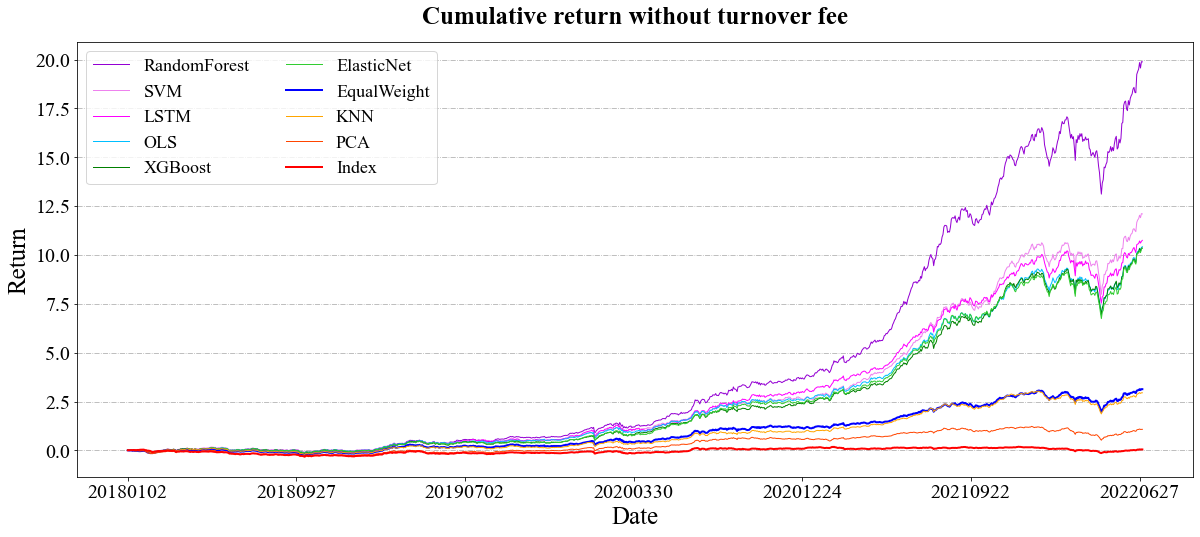

In [70]:
ax0 = draw_ret(rtn_raw_df,'Cumulative return without turnover fee')
ax0.savefig('/Users/jason/JC/公告数据/CWO_1028.jpg',dpi=200)


Index(['RandomForest', 'LSTM', 'SVM', 'ElasticNet', 'OLS', 'XGBoost',
       'EqualWeight', 'KNN', 'Index', 'PCA'],
      dtype='object')


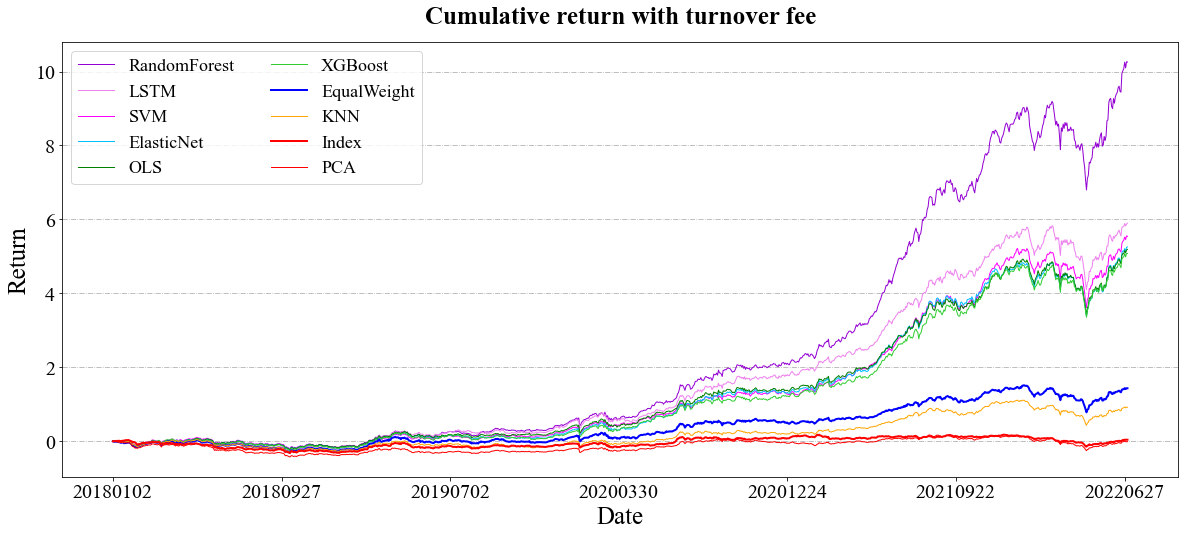

In [72]:
ax1 = draw_ret(rtn_raw_tovr_df,'Cumulative return with turnover fee')
ax1.savefig('/Users/jason/JC/公告数据/CW_1028.jpg',dpi=200)

Index(['RandomForest', 'LSTM', 'SVM', 'ElasticNet', 'OLS', 'XGBoost',
       'EqualWeight', 'KNN', 'PCA'],
      dtype='object')


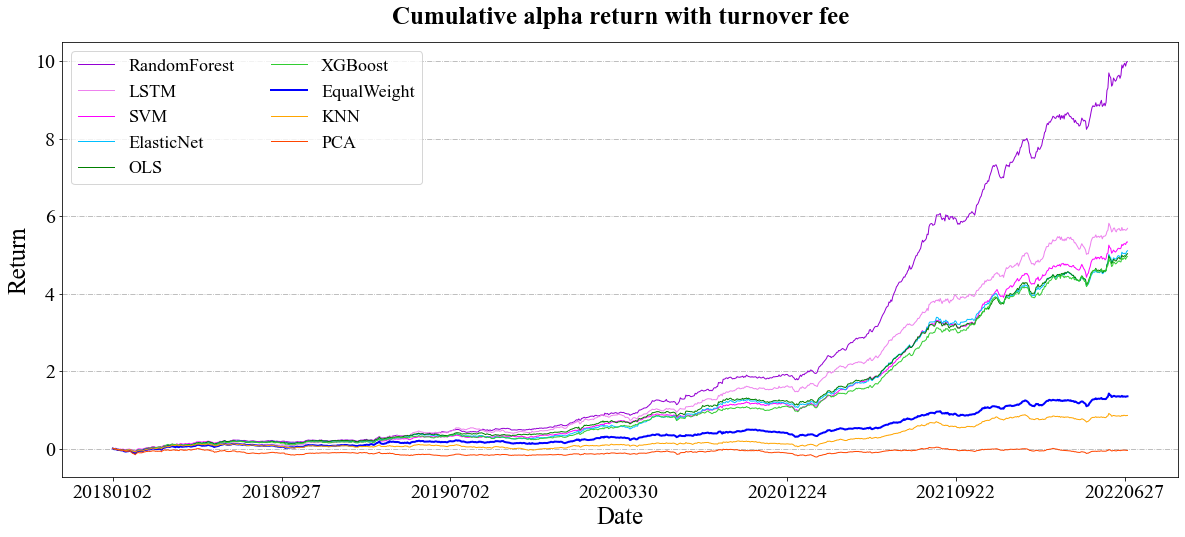

In [73]:
ax2 = draw_ret(rtn_alpha_tovr_df,'Cumulative alpha return with turnover fee')
#ax2.savefig('/Users/jason/JC/公告数据/Figures/CAW.jpg',dpi=200)

Index(['RandomForest', 'SVM', 'LSTM', 'OLS', 'XGBoost', 'ElasticNet',
       'EqualWeight', 'KNN', 'PCA'],
      dtype='object')


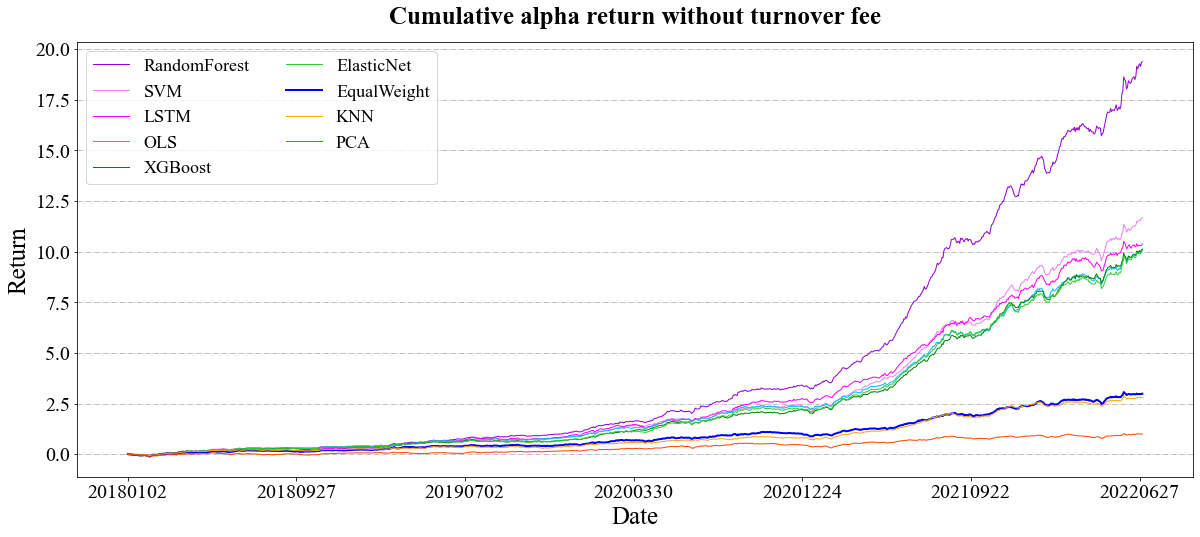

In [74]:
ax3 = draw_ret(rtn_alpha_df,'Cumulative alpha return without turnover fee')
#ax3.savefig('/Users/jason/JC/公告数据/Figures/CAWO.jpg',dpi=200)

# 不同模型收益指标对比

In [86]:
#求IC序列
def cal_ic(OLS_dict):
    date_input = list(OLS_dict['pred'].keys())
    pred_ols = OLS_dict['pred']
    ic_lst = []
    for i in range(0,len(date_input)):
        ic = pd.DataFrame([pred_ols[date_input[i]],real_ret[date_input[i]].dropna()]).T.corr().iloc[1,0]
        ic_lst.append(ic)
    
    return pd.DataFrame(ic_lst,index = date_input)

def max_drawdown(ret):
    ret_series = (ret).cumsum()
    max_drawdown = 0
    max_rtn = 0
    for rtn in ret_series:
        if rtn >= max_rtn:
            max_rtn = rtn
        else:
            drawdown = max_rtn - rtn
            if drawdown > max_drawdown:
                max_drawdown = drawdown
            else:
                pass
    return max_drawdown

In [ ]:
res_total_dict = {i:get_result_evaluation(Model_dict[i]) for i in Model_dict.keys()}

In [87]:
#求一个模型所有定量的评价
def get_result_evaluation_new(ret_df):
    print(1)
    ic = np.nan
    ic_mean = 100
    ir = 100
    
    ret = ret_df.raw
    reta = ret_df.raw - ret_df.Index
    tovr = ret_df.tovr

    ret0 = ret.mean()*252
    std0 = ret.std()*np.sqrt(252)
    shp0 = ret0/std0
    md0 = max_drawdown(ret)
    
    ret0t = (ret-tovr).mean()*252
    std0t = (ret-tovr).std()*np.sqrt(252)
    shp0t = ret0t/std0t
    md0t = max_drawdown(ret-tovr)
    
    ret1 = reta.mean()*252
    std1 = reta.std()*np.sqrt(252)
    shp1 = ret1/std1
    md1 = max_drawdown(reta)
    
    ret1t = (reta-tovr).mean()*252
    std1t = (reta-tovr).std()*np.sqrt(252)
    shp1t = ret1t/std1t
    md1t = max_drawdown(reta-tovr)
    
    turnover_rate = (tovr*2000).mean()
    
    return [{'ret':[ret0,ret1],'std':[std0,std1],'shp':[shp0,shp1],
            'Md':[md0,md1],'IR':[ic_mean,ir],'tovr_weight':[turnover_rate,turnover_rate]},{'ret':[ret0t,ret1t],'std':[std0t,std1t],'shp':[shp0t,shp1t],
            'Md':[md0t,md1t],'IR':[ic_mean,ir],'tovr_weight':[turnover_rate,turnover_rate]}]

def get_result_evaluation(OLS_dict):
    print(1)
    ic = cal_ic(OLS_dict)
    ic_mean = ic.mean()
    ir = ic.mean()/ic.std()
    
    ret_df = cal_rtn(OLS_dict,Index_ret)
    ret = ret_df.raw
    reta = ret_df.raw - ret_df.Index
    tovr = ret_df.tovr

    ret0 = ret.mean()*252
    std0 = ret.std()*np.sqrt(252)
    shp0 = ret0/std0
    md0 = max_drawdown(ret)
    
    ret1 = reta.mean()*252
    std1 = reta.std()*np.sqrt(252)
    shp1 = ret1/std1
    md1 = max_drawdown(reta)
    
    turnover_rate = (tovr*2000).mean()
    
    return {'ret':[ret0,ret1],'std':[std0,std1],'shp':[shp0,shp1],
            'Md':[md0,md1],'IR':[ic_mean,ir],'tovr_weight':[turnover_rate,turnover_rate]}


In [88]:
res_total_dict_new_0 = {i:get_result_evaluation_new(rtn_total_dict[i])[0] for i in rtn_total_dict.keys()}
res_total_dict_new_0t = {i:get_result_evaluation_new(rtn_total_dict[i])[1] for i in rtn_total_dict.keys()}

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [89]:
def to_df(res_total_dict):
    eval_sta = res_total_dict['OLS'].keys()
    res_list = []
    for i in eval_sta:
        res_list.append({j:res_total_dict[j][i] for j in res_total_dict})

    titles = ['Return','Standard deviation','Sharpe','Max drawdown','IC-IR','Turnover rate']
    res_list_norm = []
    res_list_alpha = []
    for i in res_list:
        a = i
        b = {i:a[i][0] for i in a}
        res_list_norm.append(b)
        b = {i:a[i][1] for i in a}
        res_list_alpha.append(b)

    return pd.DataFrame(res_list_norm,index = titles),pd.DataFrame(res_list_alpha,index = titles)


In [90]:
df0,df0a = to_df(res_total_dict_new_0)

dft,dfta = to_df(res_total_dict_new_0t)


In [91]:
df0

OLS         PCA         SVM         KNN  \
Return                0.596904    0.196802    0.625410    0.346568   
Standard deviation    0.257016    0.235552    0.244542    0.240145   
Sharpe                2.322441    0.835494    2.557472    1.443165   
Max drawdown          0.264932    0.405744    0.262882    0.330209   
IC-IR               100.000000  100.000000  100.000000  100.000000   
Turnover rate         1.125437    1.351815    1.275469    1.318557   

                            EN         XGB          RF          EW        LSTM  
Return                0.595593    0.596598    0.737458    0.358231    0.602746  
Standard deviation    0.258881    0.261313    0.260382    0.244400    0.254343  
Sharpe                2.300641    2.283082    2.832217    1.465756    2.369813  
Max drawdown          0.262223    0.277580    0.238863    0.319529    0.313907  
IC-IR               100.000000  100.000000  100.000000  100.000000  100.000000  
Turnover rate         1.091736    1.147100    1.136674    0.969446    0.977859

In [92]:
df0a

OLS         PCA         SVM         KNN  \
Return                0.566644    0.166542    0.595150    0.316308   
Standard deviation    0.134616    0.120040    0.121647    0.118573   
Sharpe                4.209337    1.387381    4.892426    2.667625   
Max drawdown          0.121306    0.161260    0.089045    0.093485   
IC-IR               100.000000  100.000000  100.000000  100.000000   
Turnover rate         1.125437    1.351815    1.275469    1.318557   

                            EN         XGB          RF          EW        LSTM  
Return                0.565333    0.566338    0.707197    0.327971    0.572486  
Standard deviation    0.134808    0.133633    0.136504    0.127647    0.138882  
Sharpe                4.193606    4.238011    5.180763    2.569363    4.122109  
Max drawdown          0.116976    0.070896    0.114216    0.119528    0.117453  
IC-IR               100.000000  100.000000  100.000000  100.000000  100.000000  
Turnover rate         1.091736    1.147100    1.136674    0.969446    0.977859

In [95]:
dft.round(3)

OLS      PCA      SVM      KNN       EN      XGB  \
Return                0.455    0.026    0.465    0.180    0.458    0.452   
Standard deviation    0.257    0.236    0.245    0.240    0.259    0.261   
Sharpe                1.771    0.112    1.901    0.751    1.770    1.730   
Max drawdown          0.319    0.535    0.327    0.393    0.313    0.336   
IC-IR               100.000  100.000  100.000  100.000  100.000  100.000   
Turnover rate         1.125    1.352    1.275    1.319    1.092    1.147   

                         RF       EW     LSTM  
Return                0.594    0.236    0.480  
Standard deviation    0.260    0.244    0.254  
Sharpe                2.283    0.966    1.886  
Max drawdown          0.273    0.364    0.360  
IC-IR               100.000  100.000  100.000  
Turnover rate         1.137    0.969    0.978

In [94]:
dfta

OLS         PCA         SVM         KNN  \
Return                0.424839   -0.003787    0.434441    0.150170   
Standard deviation    0.134541    0.120019    0.121613    0.118581   
Sharpe                3.157683   -0.031551    3.572330    1.266394   
Max drawdown          0.135591    0.230304    0.113119    0.152286   
IC-IR               100.000000  100.000000  100.000000  100.000000   
Turnover rate         1.125437    1.351815    1.275469    1.318557   

                            EN         XGB          RF          EW        LSTM  
Return                0.427774    0.421803    0.563976    0.205821    0.449276  
Standard deviation    0.134776    0.133674    0.136518    0.127568    0.138800  
Sharpe                3.173974    3.155461    4.131157    1.613419    3.236859  
Max drawdown          0.130729    0.118061    0.128377    0.134463    0.129255  
IC-IR               100.000000  100.000000  100.000000  100.000000  100.000000  
Turnover rate         1.091736    1.147100    1.136674    0.969446    0.977859

In [60]:
rtn_total_dict['OLS'].Index

20180102    0.003314
20180103    0.003335
20180104   -0.000174
20180105    0.006203
20180108    0.001868
              ...   
20220624   -0.001917
20220627    0.011792
20220628   -0.007050
20220629    0.005813
20220630   -0.002077
Name: Index, Length: 1090, dtype: float64

In [62]:
ret = rtn_total_dict['OLS'].Index

ret0 = ret.mean()*252
std0 = ret.std()*np.sqrt(252)
shp0 = ret0/std0
md0 = max_drawdown(ret)

[ret0,std0,shp0,md0]

[0.030260114863913227,
 0.1990177089050636,
 0.15204734809980178,
 0.16203868337557145]

OLS    PCA    SVM    KNN     EN    XGB     RF     EW  \
Return              0.597  0.197  0.625  0.347  0.596  0.597  0.737  0.358   
Standard deviation  0.257  0.236  0.245  0.240  0.259  0.261  0.260  0.244   
Sharpe              2.322  0.835  2.557  1.443  2.301  2.283  2.832  1.466   
Max drawdown        0.196  0.171  0.179  0.179  0.195  0.188  0.175  0.186   
IC-IR               0.100 -0.000  0.115  0.052  0.109  0.106  0.161  0.048   
Turnover rate       1.125  1.352  1.275  1.319  1.092  1.147  1.137  0.969   

                     LSTM  
Return              0.603  
Standard deviation  0.254  
Sharpe              2.370  
Max drawdown        0.203  
IC-IR               0.094  
Turnover rate       0.978

OLS    PCA    SVM    KNN     EN    XGB     RF     EW  \
Return              0.567  0.167  0.595  0.316  0.565  0.566  0.707  0.328   
Standard deviation  0.135  0.120  0.122  0.119  0.135  0.134  0.137  0.128   
Sharpe              4.209  1.387  4.892  2.668  4.194  4.238  5.181  2.569   
Max drawdown        0.071  0.069  0.056  0.055  0.066  0.065  0.068  0.064   
IC-IR               0.626 -0.002  0.821  0.403  0.675  0.640  0.777  0.329   
Turnover rate       1.125  1.352  1.275  1.319  1.092  1.147  1.137  0.969   

                     LSTM  
Return              0.572  
Standard deviation  0.139  
Sharpe              4.122  
Max drawdown        0.064  
IC-IR               0.631  
Turnover rate       0.978

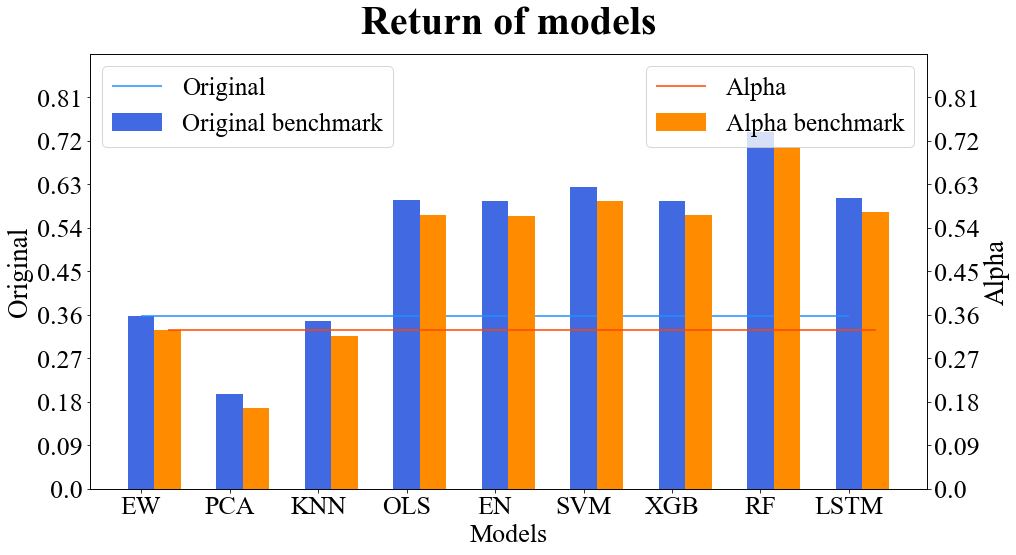

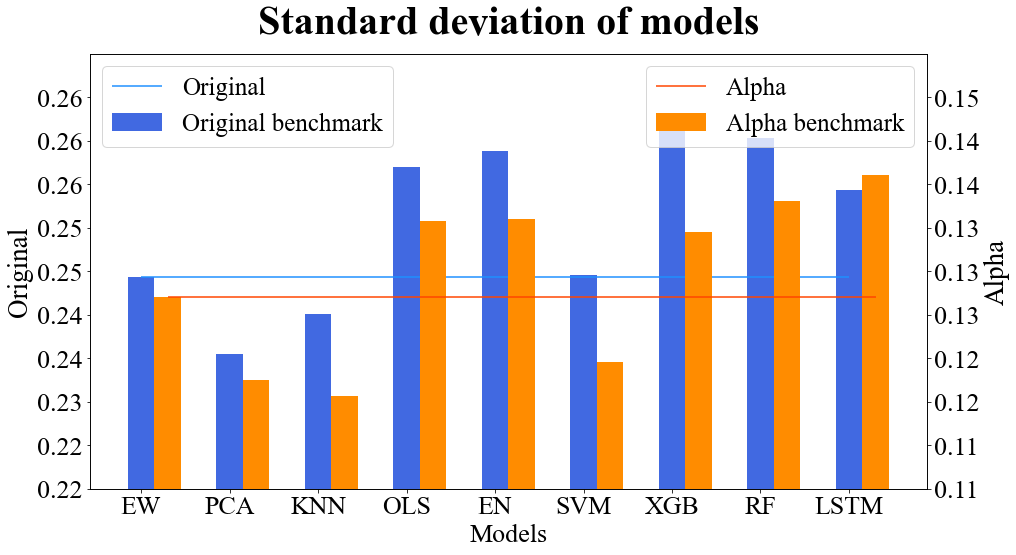

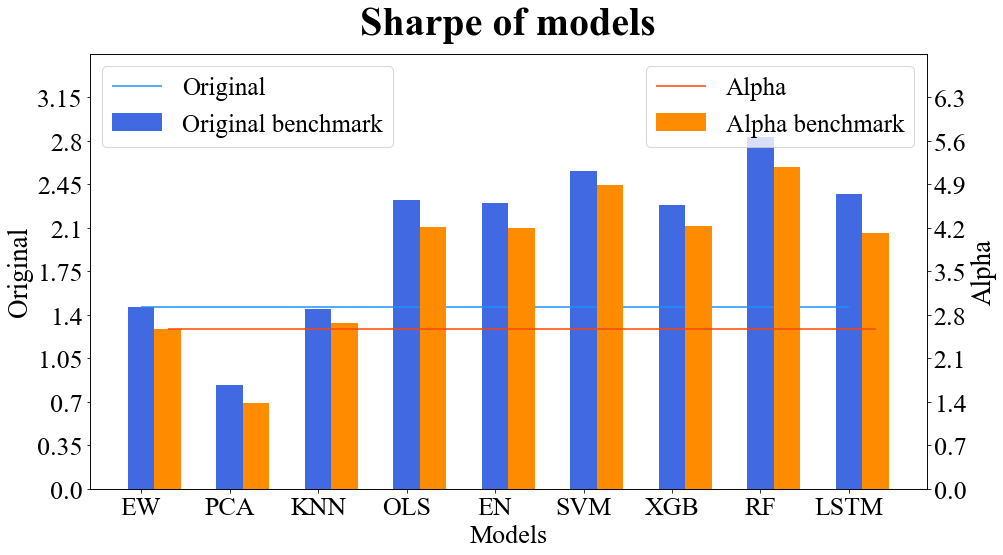

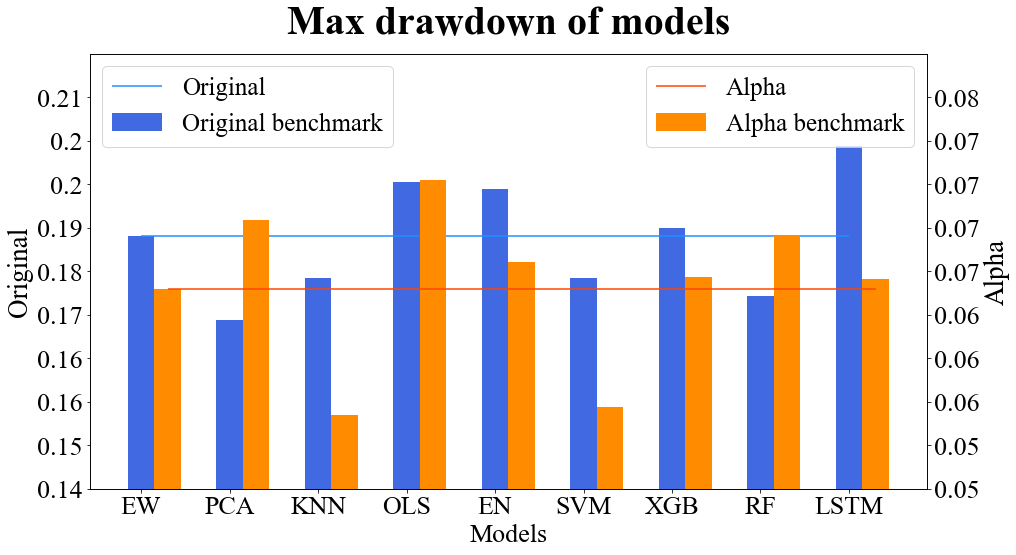

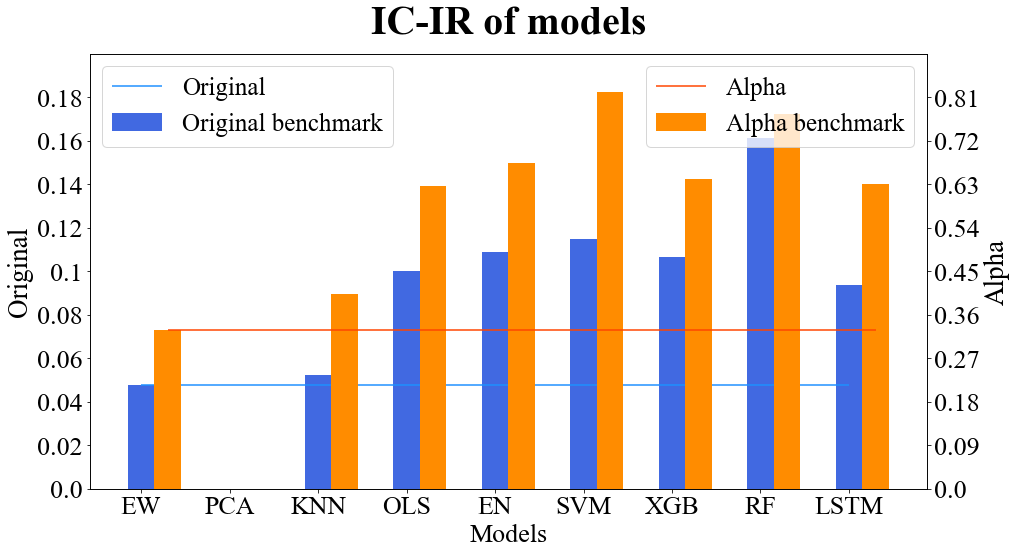

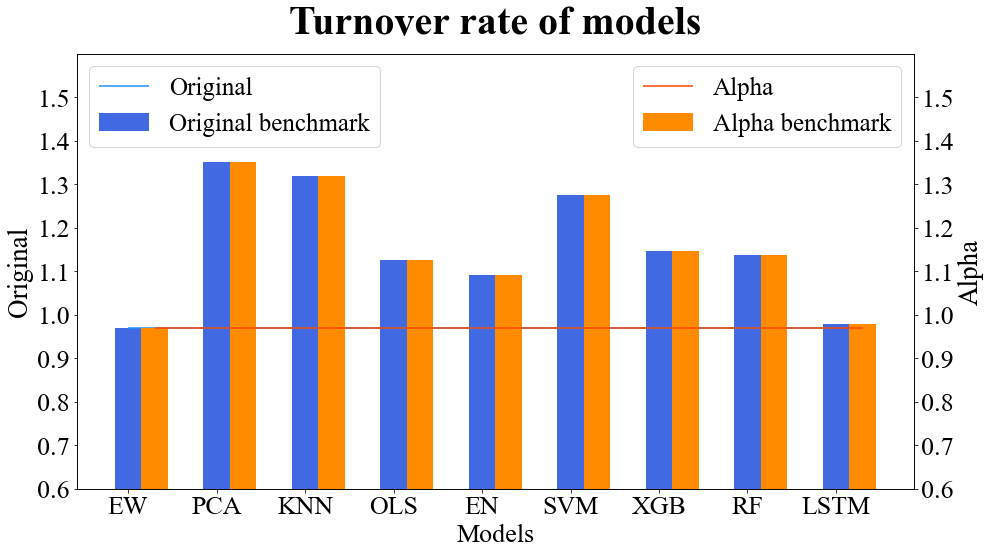

In [1175]:
plt.rcParams['font.family'] = 'Times New Roman' #设置字体
columns_list = ['EW','PCA','KNN','OLS','EN','SVM','XGB','RF','LSTM']
lim_list = [(0,0.9,0,0.9),(0.22,0.27,0.11,0.15),(0,3.5,0,7),(0.14,0.22,0.05,0.08),
            (0,0.2,0,0.9),(0.6,1.6,0.6,1.6)]
for i in range(0,6):
    a = pd.DataFrame(res_list[i])[columns_list]
    
    fig = plt.figure(figsize=(15, 8))
    plt.rcParams['font.family'] = 'Times New Roman' #设置字体
    gs = GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    
    bar_width = 0.3
    x = np.arange(len(a.loc[0]))
    ax1.bar(x,a.loc[0], bar_width,color='royalblue')
    ax1.hlines(a.loc[0].iloc[0],x[0],x[-1],color='dodgerblue')
    ax1.set_ylabel('Original',fontsize=27)
    ax1.set_xticks(np.arange(0,9))
    ax1.set_xticklabels(labels=columns_list,rotation=0,fontsize=26)
    ax1.set_ylim(lim_list[i][0],lim_list[i][1])
    y1 = np.arange(lim_list[i][0],lim_list[i][1],(lim_list[i][1]-lim_list[i][0])/10)
    ax1.set_yticks(y1)
    ax1.set_yticklabels(labels=[round(i,2) for i in y1],rotation=0,fontsize=26)
    #ax1.set_yticks(font_size=13)
    
    ax2=ax1.twinx()
    ax2.bar(x+bar_width,a.loc[1], bar_width,color='darkorange')
    ax2.hlines(a.loc[1].iloc[0],x[0]+bar_width,x[-1]+bar_width,color='orangered')
    #ax2.bar(x+2*bar_width,Result_tzM_A_df['IC_pos'], bar_width,color='skyblue')
    #ax2.hlines(Result_tzM_A_df['IC_pos'].iloc[0],x[0]+2*bar_width,x[-1]+2*bar_width,color='skyblue')
    ax2.set_ylim(lim_list[i][2],lim_list[i][3])
    y2 = np.arange(lim_list[i][2],lim_list[i][3],(lim_list[i][3]-lim_list[i][2])/10)
    ax2.set_yticks(y2)
    ax2.set_yticklabels(labels=[round(i,2) for i in y2],rotation=0,fontsize=26)
    ax2.set_ylabel('Alpha',fontsize=27)
    
    
    ax1.legend(['Original','Original benchmark'],loc='upper left',fontsize=25)
    ax2.legend(['Alpha','Alpha benchmark'],loc='upper right',fontsize=25)
    
    
    
    plt.title('{} of models'.format(titles[i]),fontsize=40,pad=20,fontproperties='Times New Roman',fontweight=600)

    #plt.yticks(fontproperties='Times New Roman', size=13)
    #plt.yticks(fontproperties='Times New Roman', size=20)
    #plt.xticks(fontproperties='Times New Roman', size=200)
    #plt.xticks(x,columns_list,fontproperties='Times New Roman', fontsize=30)
    ax1.set_xlabel('Models',fontsize=26)
    #plt.ylabel('Gain',fontsize=15,fontweight=600)
    
    plt.savefig('/Users/jason/JC/公告数据/Figures/'+titles[i]+'.jpg')
    plt.show()


In [1044]:
res_list[-1]

{'OLS': [1.1254365319892616, 1.1254365319892616],
 'PCA': [1.351814675801239, 1.351814675801239],
 'SVM': [1.2754693990489225, 1.2754693990489225],
 'KNN': [1.3185569325113529, 1.3185569325113529],
 'EN': [1.0917363458369762, 1.0917363458369762],
 'XGB': [1.1471001165502857, 1.1471001165502857],
 'RF': [1.1366743125566254, 1.1366743125566254],
 'EW': [0.9694461796201492, 0.9694461796201492],
 'LSTM': [0.9778587700676128, 0.9778587700676128]}

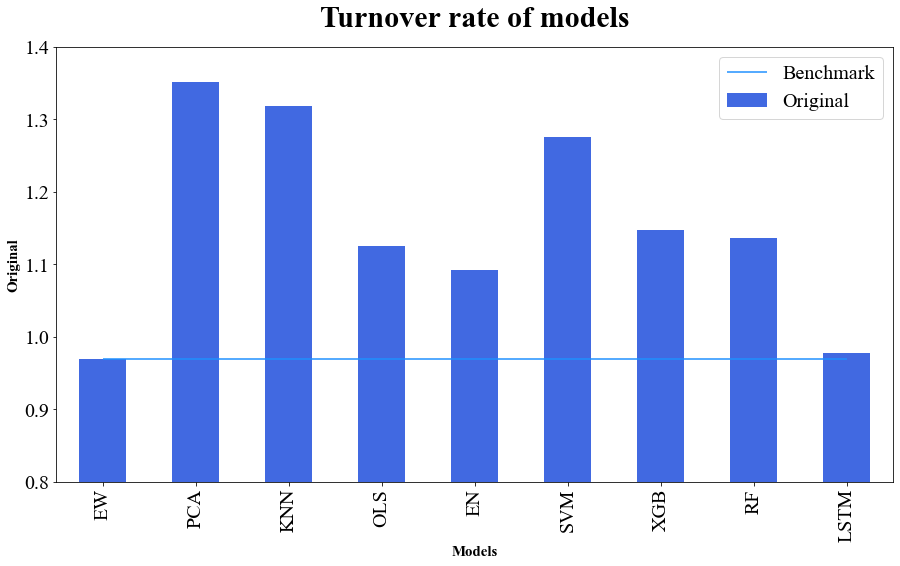

In [1036]:
plt.rcParams['font.family'] = 'Times New Roman' #设置字体

a = pd.DataFrame(res_list[-1],index = ['1'])[columns_list]
a.T.plot(kind='bar',figsize=(,8),color = ['royalblue','darkorange'])
#pd.DataFrame(res_list[i],index = ['1']).T.plot(kind='bar')
plt.hlines(a['EW'][0],0,8,color = 'dodgerblue')

plt.legend(['Benchmark','Original'],fontsize=20)
plt.title('{} of models'.format(titles[-1]),fontsize=30,pad=20,fontproperties='Times New Roman',fontweight=600)

plt.yticks(fontproperties='Times New Roman', size=20)
plt.ylim(0.8, 1.4)
plt.xticks(fontproperties='Times New Roman', size=20)
plt.xlabel('Models',fontsize=15,fontweight=600)
plt.ylabel('Original',fontsize=15,fontweight=600)
plt.show()

plt.show()

# 模型拟合程度对比

In [543]:
op = cal_e(EW_dict)
rp = cal_e(RF_dict)

In [544]:
dif = [(op[i]**2-rp[i]**2).mean() for i in range(0,len(op))]
stats.ttest_1samp(np.array(dif), 0)

Ttest_1sampResult(statistic=8.654854558393689, pvalue=1.748623905469675e-17)

In [281]:
OLS_dict['pred'][20180102].rank(pct=True)
real_ret[date_input[i]].rank(pct=True)

8         0.515625
402       0.250000
415       0.468750
599       0.781250
687       0.734375
            ...   
603311    0.234375
603569    0.906250
603679    0.359375
603839    0.078125
603843    0.796875
Length: 64, dtype: float64

In [599]:
#求模型的比较，返回t和p矩阵
def cal_e(OLS_dict):
    pred_ols = OLS_dict['pred']
    date_input = list(OLS_dict['pred'].keys())
    error_lst = []
    for i in range(0,len(date_input)):
        pred = pred_ols[date_input[i]].rank(pct=True)
        real = real_ret[date_input[i]].dropna().loc[pred.index].rank(pct=True)
        error = np.sqrt((pred - real)**2)
        error_lst.append(error)
    return np.array(error_lst)

from scipy import stats
def cal_compare(e1,e2):
    dif = pd.Series([(e1[i]**2-e2[i]**2).mean() for i in range(0,len(e1))])
    #dif = (e1**2-e2**2)
    #print(dif)
    #t = dif.mean()/dif.std()
    v,p = stats.ttest_1samp(dif.fillna(dif.mean()), 0)
    return dif.mean(),v,p

def cal_comparison_matrix(dict_list):
    error_all = [cal_e(i) for i in dict_list]
    v_mat = np.zeros([len(error_all),len(error_all)])
    p_mat = np.zeros([len(error_all),len(error_all)])
    dif_mat = np.zeros([len(error_all),len(error_all)])
    for i in range(0,len(error_all)):
        for j in range(i,len(error_all)):
            dif,v,p = cal_compare(error_all[i],error_all[j])
            dif_mat[i][j] = dif
            dif_mat[j][i] = -dif
            v_mat[i][j] = v
            v_mat[j][i] = -v
            p_mat[i][j] = p
            p_mat[j][i] = -p
    return v_mat,p_mat,dif_mat

In [600]:
v_mat,p_mat,dif_mat = cal_comparison_matrix([Model_dict[i] for i in Model_dict])

In [570]:
v_df = pd.DataFrame(v_mat,index = Model_dict.keys(),columns = Model_dict.keys()).fillna(0)

In [610]:
dif_df = pd.DataFrame(dif_mat,index = Model_dict.keys(),columns = Model_dict.keys()).fillna(0)

In [611]:
l = list(dif_df.columns)
for i in dif_df.columns:
    for j in dif_df.index:
        a = l.index(j)
        b = l.index(i)
        if dif_df.loc[j,i]>0:
            if a>b:
                l[a] = i
                l[b] = j
        else:
            if a<b:
                l[a] = i
                l[b] = j

In [612]:
l

['PCA', 'EW', 'KNN', 'LSTM', 'OLS', 'EN', 'XGB', 'RF', 'SVM']

In [613]:
#l = ['PCA', 'EW', 'KNN','LSTM', 'OLS','EN', 'XGB', 'RF', 'SVM']

In [614]:
Add_list = []
std_list = []
for i in range(0,len(l)-1):
    a = l[i]
    b = l[i+1]
    Add_list.append(dif_df.loc[a,b])
    std_list.append(dif_df.loc[a,b]/v_df.loc[a,b])

In [615]:
Add_list

[0.0018866907171560098,
 0.003537483500276055,
 0.0017716694231516448,
 0.0007813795376438808,
 0.00036900892265002234,
 0.0006518515930589795,
 0.0008914713495653847,
 0.002150456906563748]

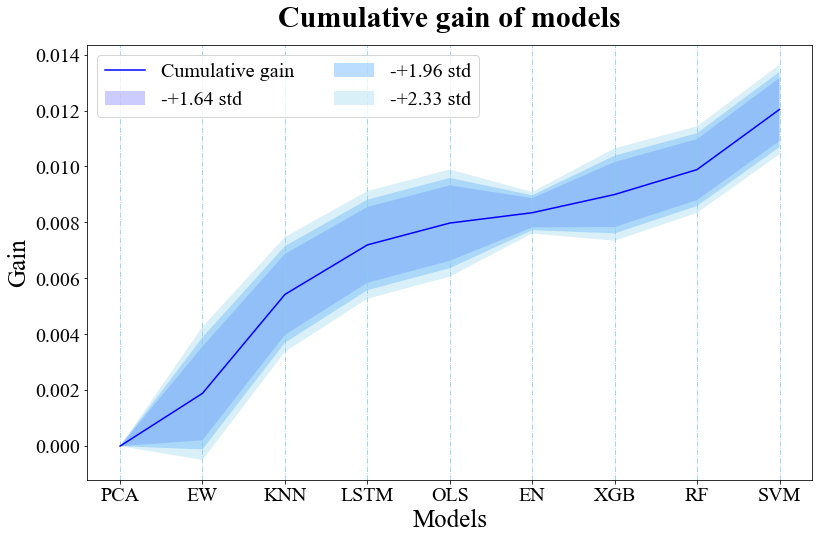

In [1171]:
plt.figure(figsize=(13,8))
plt.grid(linestyle='-.',axis='x',color='skyblue')
plt.plot(pd.Series([0]+Add_list).cumsum(),color = 'blue')
plt.fill_between(np.arange(len(Add_list)+1),(pd.Series([0]+Add_list).cumsum()-1.64*pd.Series([0]+std_list)),
                 (pd.Series([0]+Add_list).cumsum()+1.64*pd.Series([0]+std_list))
                ,alpha=0.2,facecolor = 'blue')
plt.fill_between(np.arange(len(Add_list)+1),(pd.Series([0]+Add_list).cumsum()-1.96*pd.Series([0]+std_list)),
                 (pd.Series([0]+Add_list).cumsum()+1.96*pd.Series([0]+std_list))
                ,alpha=0.3,facecolor = 'dodgerblue')
plt.fill_between(np.arange(len(Add_list)+1),(pd.Series([0]+Add_list).cumsum()-2.33*pd.Series([0]+std_list)),
                 (pd.Series([0]+Add_list).cumsum()+2.33*pd.Series([0]+std_list))
                ,alpha=0.3,facecolor = 'skyblue')

#plt.plot((pd.Series([0]+Add_list)+1.96*pd.Series([0]+std_list)))
#plt.plot((pd.Series([0]+Add_list)-1.96*pd.Series([0]+std_list)))
plt.xticks(np.arange(len(Add_list)+1),l)
plt.rcParams['font.family'] = 'Times New Roman' #设置字体
plt.legend(['Cumulative gain','-+1.64 std','-+1.96 std','-+2.33 std'],fontsize=20,ncol = 2,loc='upper left')
plt.title('Cumulative gain of models',fontsize=30,pad=18,fontproperties='Times New Roman',fontweight=600)

plt.yticks(fontproperties='Times New Roman', size=20)
plt.xticks(fontproperties='Times New Roman', size=20)
plt.xlabel('Models',fontsize=25)
plt.ylabel('Gain',fontsize=25)

plt.savefig('/Users/jason/JC/公告数据/Figures/Cumgain.jpg',dpi=200)
plt.show()

In [931]:
v_df = pd.DataFrame(v_mat,index = Model_dict.keys(),columns = Model_dict.keys()).fillna(0)

In [932]:
p_df = pd.DataFrame(p_mat,index = Model_dict.keys(),columns = Model_dict.keys()).fillna(0)

In [934]:
v_df1 = v_df.copy()
for i in range(0,len(v_df)):
    for j in range(0,len(v_df)):
        if i>=j:
            v_df1.iloc[i,j] = ''
        else:
            if p_df.iloc[i,j] <= 0.01:
                a = '***'
            elif p_df.iloc[i,j] <= 0.05:
                a = '**'
            elif p_df.iloc[i,j] <= 0.1:
                a = '*'
            else:
                a = ''
                
            v_df1.iloc[i,j] = str(round(v_df.iloc[i,j],3)) + a

In [939]:
v_df.abs().mean().mean()

4.578031524660765

# 特征重要性

In [314]:
#求特征重要性，按照分组返回平均数以及标准差
def cal_feature_importance(OLS_dict):
    importance_mat = pd.concat([OLS_dict['model'][i] for i in OLS_dict['model']],axis=1).T
    importance_mat.index = OLS_dict['model'].keys()
    importance_mat = ((importance_mat.T - importance_mat.mean(axis=1))/importance_mat.std(axis=1)).T
    #importance_mat.reset_index().drop(columns = ['index']).plot()
    mean_imp = pd.DataFrame([importance_mat.iloc[:,i:i+6].mean(axis=1) for i in range(0,42,6)]).T
    mean_imp.columns = ['MACD','RSI','KDJ','BOLL','VOL','CHA','TRD']
    std_imp = pd.DataFrame([importance_mat.iloc[:,i:i+6].std(axis=1) for i in range(0,42,6)]).T
    std_imp.columns = ['MACD','RSI','KDJ','BOLL','VOL','CHA','TRD']
    return mean_imp,std_imp


In [471]:
Model_dict.keys()

dict_keys(['OLS', 'PCA', 'SVM', 'KNN', 'EN', 'XGB', 'RF', 'EW'])

In [496]:
fi_ser_lst = []
for i in Model_dict:
    if i == 'KNN' or i == 'EW':
        continue
    fi_ser_lst.append(pd.concat(Model_dict[i]['model'],axis=1).mean(axis=1))
fi_ser_df = pd.DataFrame(fi_ser_lst,index = ['OLS', 'PCA', 'SVM', 'EN', 'XGB', 'RF'])
fi_ser_df = ((fi_ser_df.T - fi_ser_df.mean(axis=1))/fi_ser_df.std(axis=1))
ind = fi_ser_df.mean(axis=1).sort_values(ascending=False).index
fi_ser_df = fi_ser_df.loc[ind]

In [1056]:
fac_name_list = ['Mom_1', 'Ret_4', 'Mom_4', 'Mom_3', 'Trd_2', 'Boll_6', 'Ret_3', 'Trd_1',
       'Ret_6', 'RSI_3', 'Boll_4', 'Mom_2', 'Ret_5', 'Trd_6', 'MACD_1',
       'KDJ_5', 'Ret_2', 'RSI_5', 'Trd_3', 'KDJ_4', 'KDJ_1', 'MACD_3', 'Mom_5',
       'MACD_4', 'MACD_5', 'MACD_6', 'Boll_3', 'RSI_4', 'KDJ_6', 'RSI_6',
       'Mom_6', 'Trd_5', 'Ret_1', 'RSI_2', 'KDJ_2', 'KDJ_3', 'Boll_2', 'RSI_1',
       'MACD_2', 'Boll_5', 'Boll_1', 'Trd_4']

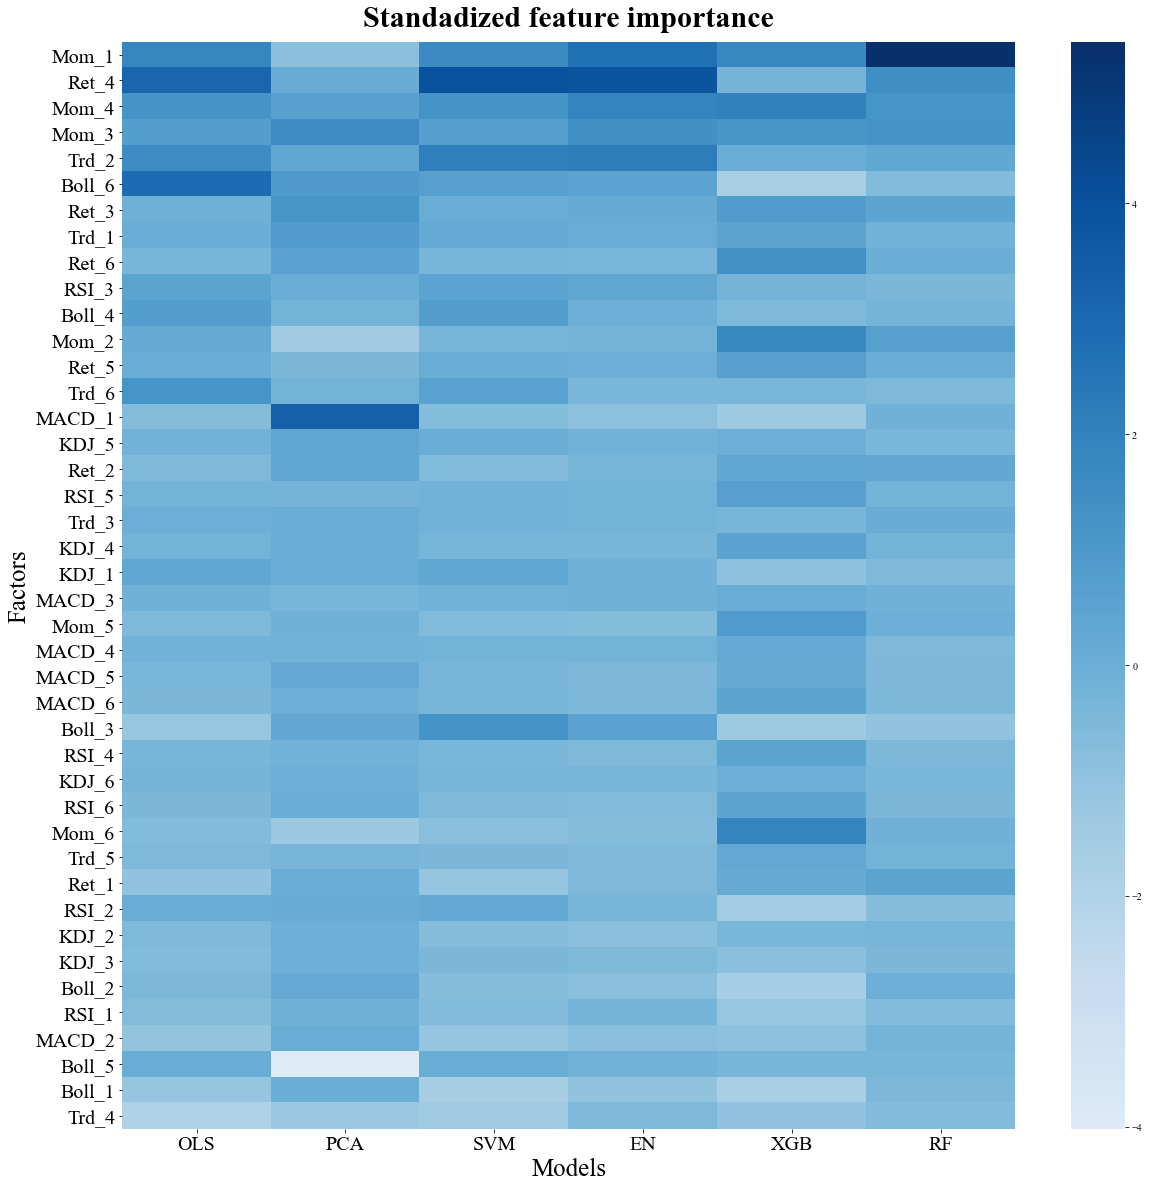

In [1172]:
fi_ser_df.index = fac_name_list
plt.rcParams['font.family'] = 'Times New Roman' #设置字体
plt.figure(figsize=(20,20))
sns.heatmap(fi_ser_df,cmap='Blues',annot_kws={"size": 20},center = 0)
plt.title('Standadized feature importance',fontsize=30,pad=15,fontproperties='Times New Roman',fontweight=600)
plt.yticks(fontproperties='Times New Roman', size=20)
plt.xticks(fontproperties='Times New Roman', size=20)
plt.xlabel('Models',fontsize=25)
plt.ylabel('Factors',fontsize=25)
plt.savefig('/Users/jason/JC/公告数据/Figures/FIHM.jpg',dpi=200)
plt.show()

In [1078]:
def draw_fi(OLS_dict,title,weight):
    m,s = cal_feature_importance(OLS_dict)
    ind = m.cumsum().iloc[-1,:].sort_values(ascending=False).index

    m.index = [str(i) for i in m.index]
    s.index = [str(i) for i in s.index]
    m = m[ind]
    s = s[ind]
    mid = m.cumsum()
    down = (m-weight*s).cumsum()
    up = (m+weight*s).cumsum()
    #up = mid + weight*s
    #down = mid - weight*s
    
    fig = plt.figure(figsize=(15, 8))
    plt.rcParams['font.family'] = 'Times New Roman' #设置字体
    gs = GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    #ax2 = fig.add_subplot(gs[0, 1])
    clrs1=['darkviolet','darkblue','deepskyblue','green','magenta','orangered','red']
    clrs2=['olive','magenta','darkblue','orange','deepskyblue','limegreen','darkviolet','blue','red']
    names = list(mid.columns)
    for i in range(mid.shape[1]):
        ax1.plot(mid[names[i]],clrs1[i])
        plt.fill_between(mid.index,up[names[i]],down[names[i]],facecolor = clrs1[i],alpha = 0.2)
    ax1.set_xticks(mid.index[::int(len(list(mid.index))/6)])
    names = ['High-moment features','Return features','Bolling band','Trade volume','KDJ','RSI','MACD']
    ax1.legend(names,loc = 'upper left',ncol = 2,fontsize=20)
    #ax1.set_title('Culmulative feature importance of {} (-+0.01 std)'.format(title),fontsize=15,pad=10)
    
    
    plt.title('Culmulative feature importance of {} (-+0.01 std)'.format(title),fontsize=30,pad=15,fontproperties='Times New Roman',fontweight=600)
    plt.yticks(fontproperties='Times New Roman', size=20)
    plt.xticks(fontproperties='Times New Roman', size=20)
    plt.xlabel('Date',fontsize=25)
    plt.ylabel('Standardized feature importance',fontsize=25)
    return plt

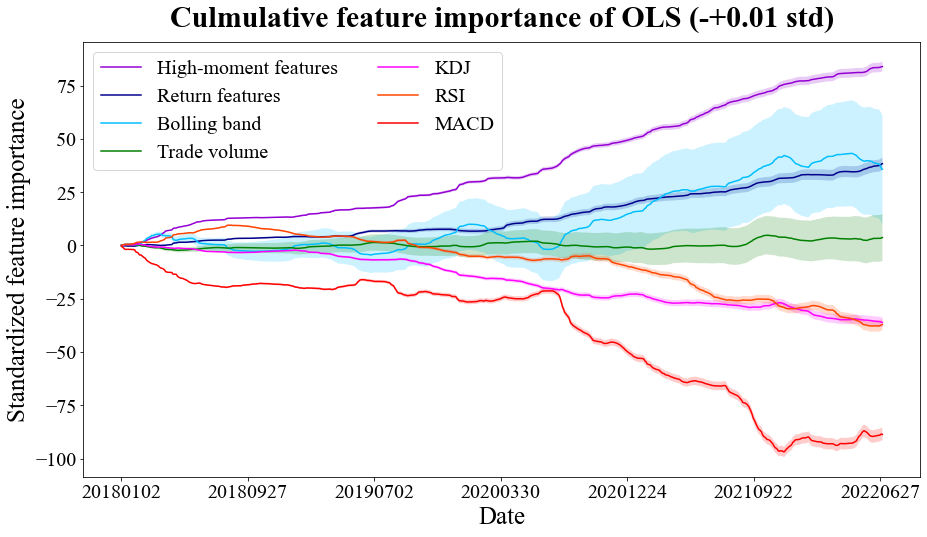

In [1079]:
fx = draw_fi(OLS_dict,'OLS',0.01)
fx.savefig('/Users/jason/JC/公告数据/Figures/CFIOLS.jpg',dpi=300)

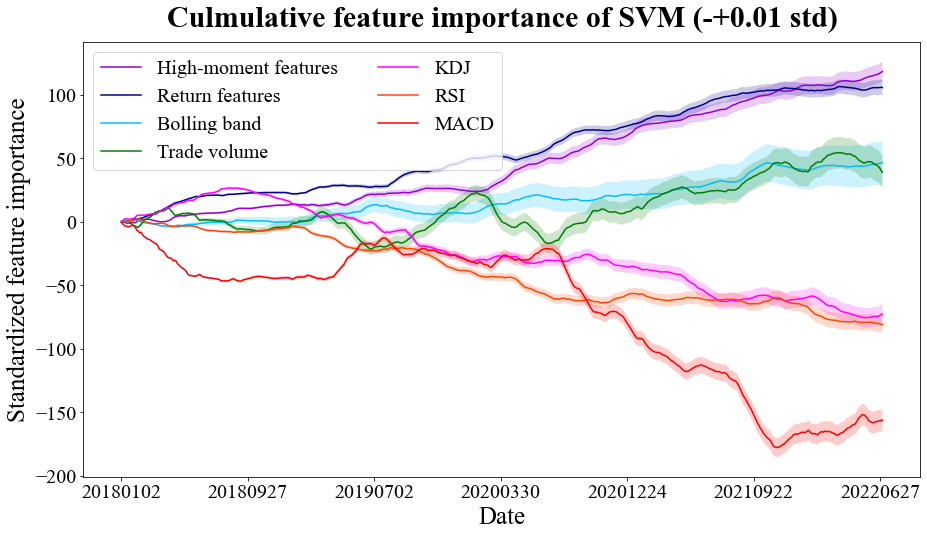

In [1080]:
fx = draw_fi(SVM_dict,'SVM',0.01)
fx.savefig('/Users/jason/JC/公告数据/Figures/CFISVM.jpg',dpi=300)

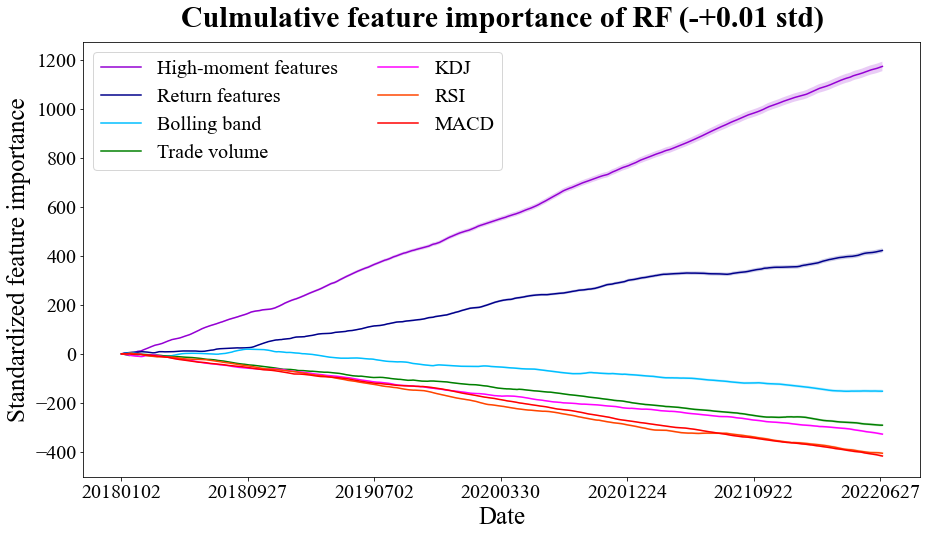

In [1081]:
fx = draw_fi(RF_dict,'RF',0.01)
fx.savefig('/Users/jason/JC/公告数据/Figures/RF.jpg',dpi=300)

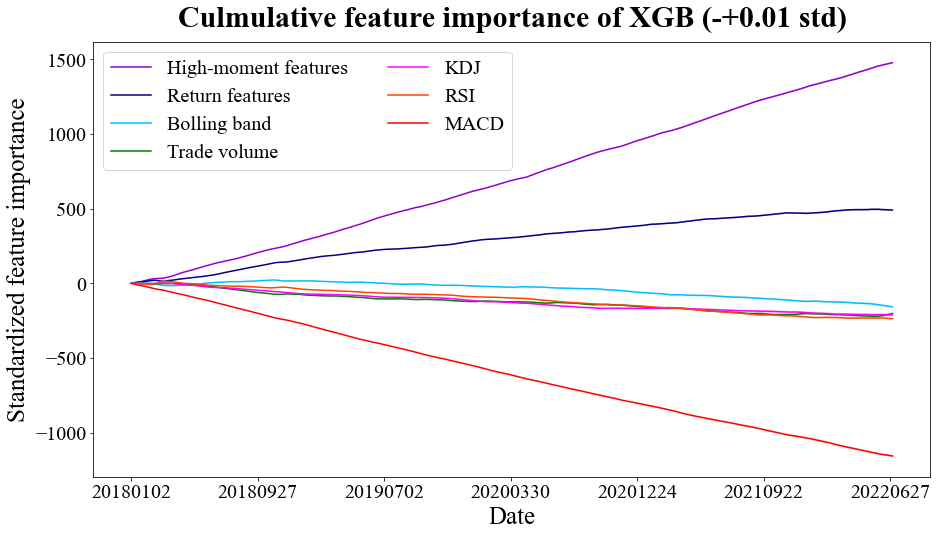

In [1082]:
fx = draw_fi(XGB_dict,'XGB',0.01)
fx.savefig('/Users/jason/JC/公告数据/Figures/CFIXGB.jpg',dpi=300)

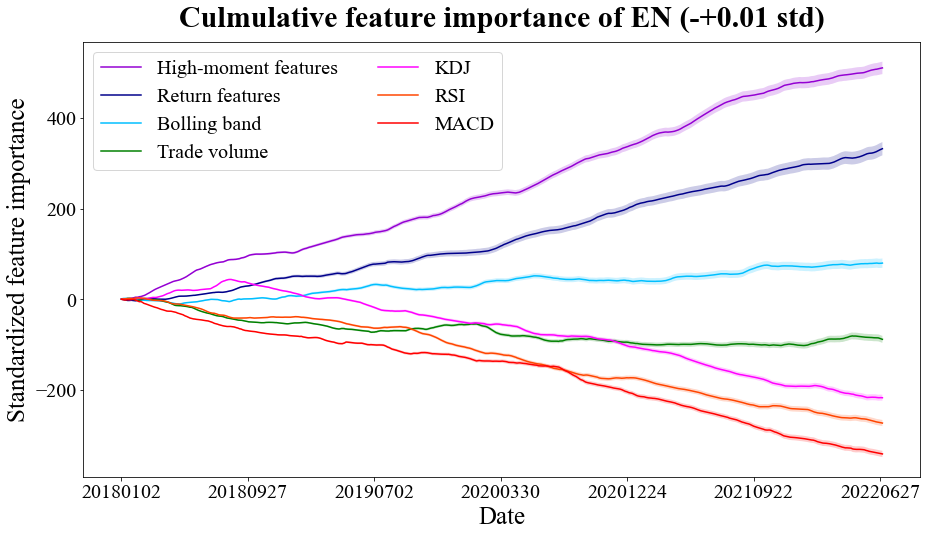

In [1083]:
fx = draw_fi(EN_dict,'EN',0.01)
fx.savefig('/Users/jason/JC/公告数据/Figures/EN.jpg',dpi=300)

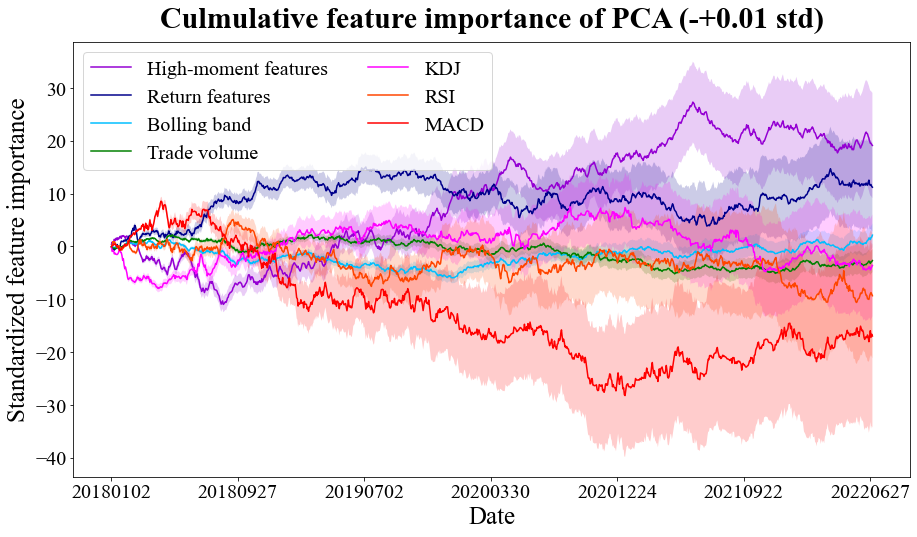

In [1084]:
fx = draw_fi(PCA_dict,'PCA',0.01)
fx.savefig('/Users/jason/JC/公告数据/Figures/CFIPCA.jpg',dpi=300)

# 模型对公告的重视程度

In [1153]:
t.columns[60:-20]

Index(['20180102', '20180103', '20180104', '20180105', '20180108', '20180109',
       '20180110', '20180111', '20180112', '20180115',
       ...
       '20220617', '20220620', '20220621', '20220622', '20220623', '20220624',
       '20220627', '20220628', '20220629', '20220630'],
      dtype='object', length=1090)

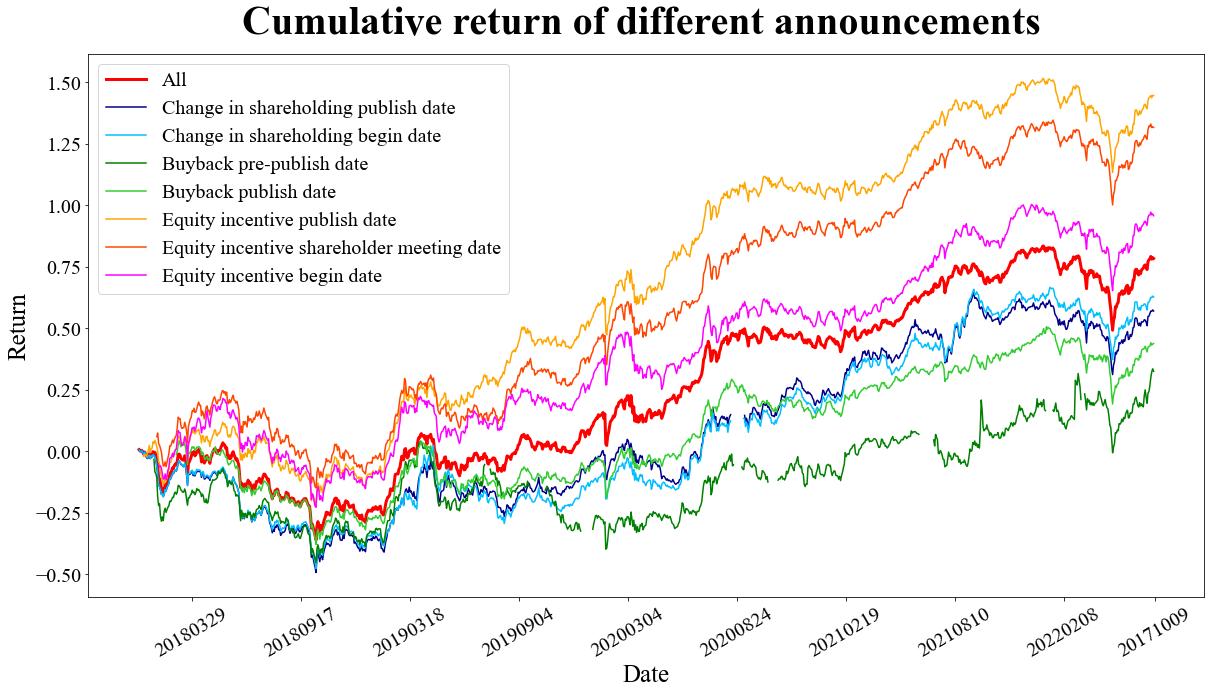

In [1176]:
fig = plt.figure(figsize=(20,10))
plt.rcParams['font.family'] = 'Times New Roman' #设置字体
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
plt.rcParams['font.family'] = 'Times New Roman' #设置字体
clrs1=['darkviolet','darkblue','deepskyblue','green','limegreen','orange','orangered','magenta','red']
t = signal_df * real_ret
t.columns = [str(i) for i in t]
ax1.plot(((t.iloc[:,60:-20]).mean().cumsum()),color = 'red',markersize=0.5, linewidth=3)
j=1
for i in ann_dict:
    t = ann_dict[i] * real_ret
    t.columns = [str(i) for i in t]
    ax1.plot(((t.iloc[:,60:-20]).mean().cumsum()),color = clrs1[j])
    j+=1
xt = [str(i) for i in signal_df.T.index][60:-20]
ax1.set_xticks(t.columns[::int(len(t.columns)/10)])
names = ['Change in shareholding publish date', 'Change in shareholding begin date', 
         'Buyback pre-publish date', 'Buyback publish date', 'Equity incentive publish date',
         'Equity incentive shareholder meeting date', 'Equity incentive begin date']
ax1.legend(['All']+names,loc = 'upper left',ncol = 1,fontsize=20)

plt.title('Cumulative return of different announcements ',fontsize=40,pad=20,fontproperties='Times New Roman',fontweight=600)
plt.yticks(fontproperties='Times New Roman', size=20)
plt.xticks(fontproperties='Times New Roman', size=20,rotation=30)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Return',fontsize=25)



#ax1.set_title('Culmulative feature importance of {} (-+0.01 std)'.format(title),fontsize=15,pad=10)


plt.savefig('/Users/jason/JC/公告数据/Figures/RollHoldRtn.jpg',dpi=300)
plt.show()

In [588]:
#求权重用，返回权重以及经过调整后的权重
def cal_ann_weight(OLS_dict,ann_dict):
    print(1)
    All_weight = []
    for j in OLS_dict['weight'].keys():
        index_exist = OLS_dict['weight'][j].columns
        weight_total = []
        for i in ann_dict.keys():
            index_ann = set(ann_dict[i][j].dropna().index)
            index = list(index_ann & set(index_exist))
            w = float(OLS_dict['weight'][j][index].sum(axis=1))
            weight_total.append(w)
        All_weight.append(weight_total)
    weights_total = pd.DataFrame(All_weight,index = OLS_dict['weight'].keys(),columns = ann_dict.keys())

    a = pd.DataFrame([ann_dict[i].sum() for i in ann_dict]).T
    a = a.div(a.sum(axis=1),axis=0)
    a.columns = ann_dict.keys()
    weights_weighted = (weights_total/a.loc[weights_total.index]).fillna(0)

    return weights_total,weights_weighted



In [589]:
acc_dict = {i:cal_ann_weight(Model_dict[i],ann_dict)[1] for i in Model_dict }

1
1
1
1
1
1
1
1
1


In [909]:
acc_dict['OLS']

chg_pub   chg_bgn    bb_pre    bb_pub   exe_pub   exe_shc   exe_ini
20180102  1.788971  1.967345  0.000000  0.000000  0.000000  0.000000  0.000000
20180103  1.993931  1.984615  0.000000  0.000000  0.000000  0.000000  0.000000
20180104  1.910764  1.892462  0.000000  0.000000  0.000000  0.000000  0.000000
20180105  1.891385  1.981818  0.000000  0.000000  0.000000  0.000000  0.000000
20180108  1.832801  1.949550  0.000000  0.000000  0.000000  0.000000  0.000000
...            ...       ...       ...       ...       ...       ...       ...
20220624  2.024550  2.055882  1.787089  0.865917  1.613164  1.596277  1.349548
20220627  1.178773  1.183213  1.971544  0.999034  2.110386  1.382888  1.061783
20220628  2.240780  2.413148  2.229767  0.763573  1.735601  1.174809  1.103955
20220629  0.935030  0.935030  1.989091  1.005144  1.861726  1.373218  1.108862
20220630  1.481808  1.605292  2.907091  1.335322  1.675843  1.090639  1.005504

[1090 rows x 7 columns]

In [773]:
total_acc = {}
for i in acc_dict['OLS'].columns:
    a = pd.DataFrame([acc_dict[j][i] for j in acc_dict]).T
    a.index = [str(i) for i in a.index]
    total_acc[i] = a

In [907]:
total_acc['chg_pub']

chg_pub   chg_pub   chg_pub   chg_pub   chg_pub   chg_pub  \
20180102  1.788971  1.978074  1.854418  1.709338  1.698754  1.646317   
20180103  1.993931  1.909893  1.880113  1.967149  1.976675  1.810427   
20180104  1.910764  1.902548  1.846502  1.900780  1.892854  1.906426   
20180105  1.891385  1.938020  1.890994  1.854269  1.795991  1.883013   
20180108  1.832801  1.779129  1.931135  1.811707  1.855242  1.829220   
...            ...       ...       ...       ...       ...       ...   
20220624  2.024550  2.147610  1.580187  1.400840  1.638720  1.482217   
20220627  1.178773  1.376525  1.782289  1.560018  0.810638  1.114508   
20220628  2.240780  2.144391  2.136890  1.425927  1.973674  0.546898   
20220629  0.935030  1.019109  0.131815  1.923298  1.112600  0.895553   
20220630  1.481808  1.907779  1.807120  1.588962  1.011798  0.851584   

           chg_pub   chg_pub   chg_pub  
20180102  1.650042  1.690301  1.750786  
20180103  1.838197  1.879864  1.963483  
20180104  1.909132  1.847554  1.839656  
20180105  1.878781  1.905752  1.895137  
20180108  1.896056  1.885728  1.822161  
...            ...       ...       ...  
20220624  2.018052  0.705148  2.221994  
20220627  0.921631  1.138538  1.698850  
20220628  1.577596  1.236278  1.972460  
20220629  1.405391  2.712046  2.578358  
20220630  1.310584  2.213883  2.456107  

[1090 rows x 9 columns]

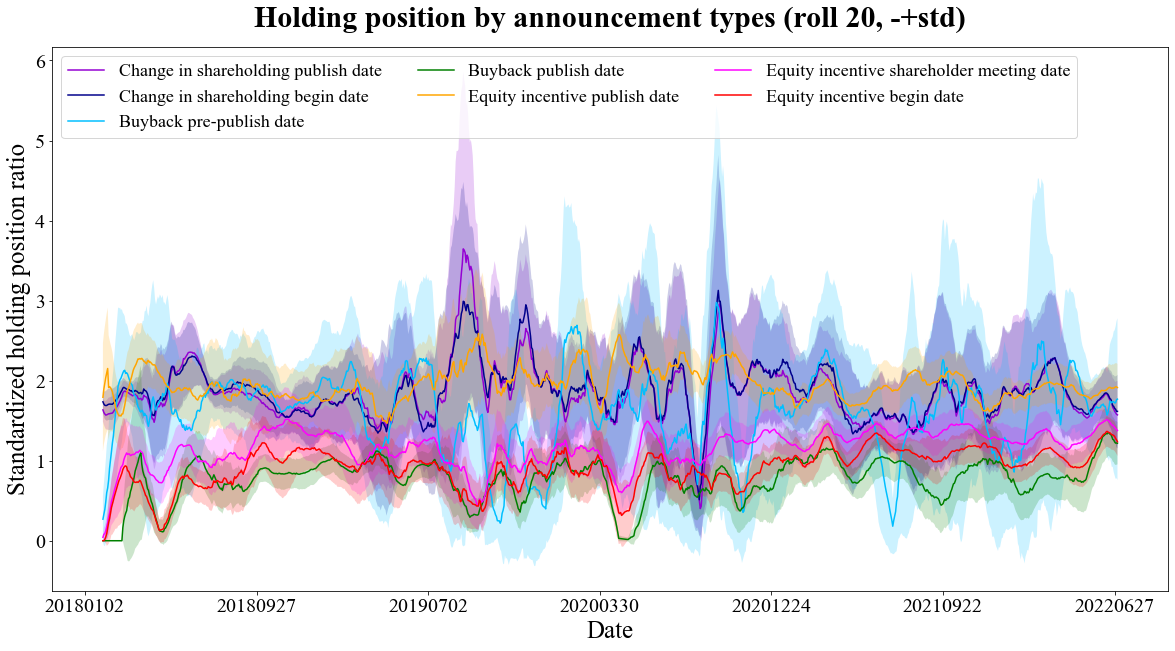

In [1108]:
fig = plt.figure(figsize=(20,10))
plt.rcParams['font.family'] = 'Times New Roman' #设置字体
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
#ax2 = fig.add_subplot(gs[0, 1])
clrs1=['darkviolet','darkblue','deepskyblue','green','orange','magenta','red']
names = list(total_acc.keys())
for i in range(len(total_acc)):
    mid = (total_acc[names[i]].mean(axis=1).rolling(window=20)).mean()
    down = (total_acc[names[i]].mean(axis=1) - total_acc[names[i]].std(axis=1)).rolling(window=20).mean()
    up = (total_acc[names[i]].mean(axis=1) + total_acc[names[i]].std(axis=1)).rolling(window=20).mean()
    ax1.plot(mid,clrs1[i])
    plt.fill_between(total_acc[names[i]].index,up,down,facecolor = clrs1[i],alpha = 0.2)
ax1.set_xticks(total_acc[names[i]].index[::int(len(list(total_acc[names[i]].index))/6)])
names = ['Change in shareholding publish date', 'Change in shareholding begin date', 
         'Buyback pre-publish date', 'Buyback publish date', 'Equity incentive publish date',
         'Equity incentive shareholder meeting date', 'Equity incentive begin date']
ax1.legend(names,loc = 'upper left',ncol = 3,fontsize=18)

plt.title('Holding position by announcement types (roll 20, -+std)',fontsize=30,pad=20,fontproperties='Times New Roman',fontweight=600)
plt.yticks(fontproperties='Times New Roman', size=20)
plt.xticks(fontproperties='Times New Roman', size=20)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Standardized holding position ratio',fontsize=25)

plt.savefig('/Users/jason/JC/公告数据/Figures/RollHold.jpg',dpi=300)

plt.show()
#ax1.set_title('Culmulative feature importance of {} (-+0.01 std)'.format(title),fontsize=15,pad=10)

In [905]:
def draw_hold(j,name):
    fig = plt.figure(figsize=(15, 8))
    plt.rcParams['font.family'] = 'Times New Roman' #设置字体
    gs = GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    #ax2 = fig.add_subplot(gs[0, 1])
    clrs1=['darkviolet','darkblue','deepskyblue','green','orange','magenta','red']
    names = list(total_acc.keys())
    for i in range(len(total_acc)):
        mid = (total_acc[names[i]].iloc[:,j].rolling(window=20)).mean()
        ax1.plot(mid,clrs1[i])
        #plt.fill_between(total_acc[names[i]].index,up,down,facecolor = clrs1[i],alpha = 0.2)
    ax1.set_xticks(total_acc[names[i]].index[::int(len(list(total_acc[names[i]].index))/6)])
    names = ['chg_pub', 'chg_bgn', 'bb_pre', 'bb_pub', 'exe_pub', 'exe_shc', 'exe_ini']
    ax1.legend(names,loc = 'upper left',ncol = 2,fontsize=13)

    plt.title('Holding position by {} (roll 20, -+std)'.format(name),fontsize=18,pad=15,fontproperties='Times New Roman',fontweight=600)
    plt.yticks(fontproperties='Times New Roman', size=13)
    plt.xticks(fontproperties='Times New Roman', size=13)
    plt.xlabel('Date',fontsize=15,fontweight=600)
    plt.ylabel('Standardized holding position ratio',fontsize=15,fontweight=600)
    plt.show()
    #ax1.set_title('Culmulative feature importance of {} (-+0.01 std)'.format(title),fontsize=15,pad=10)

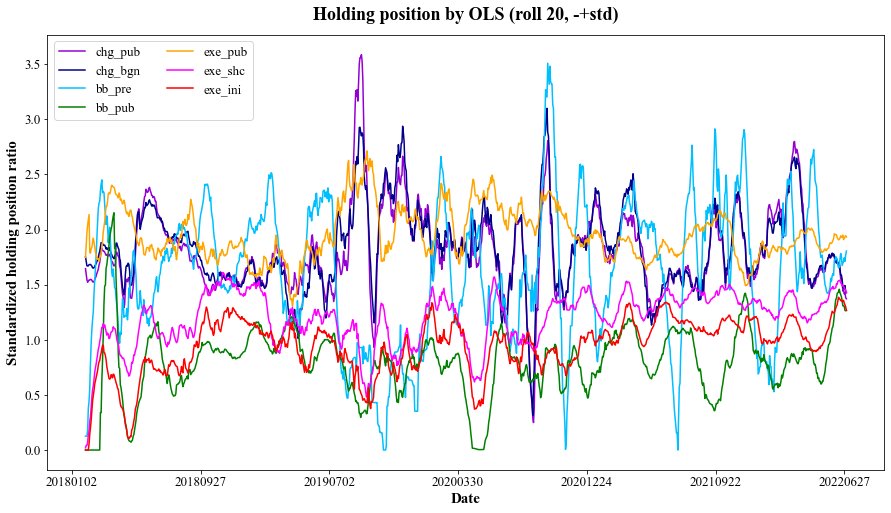

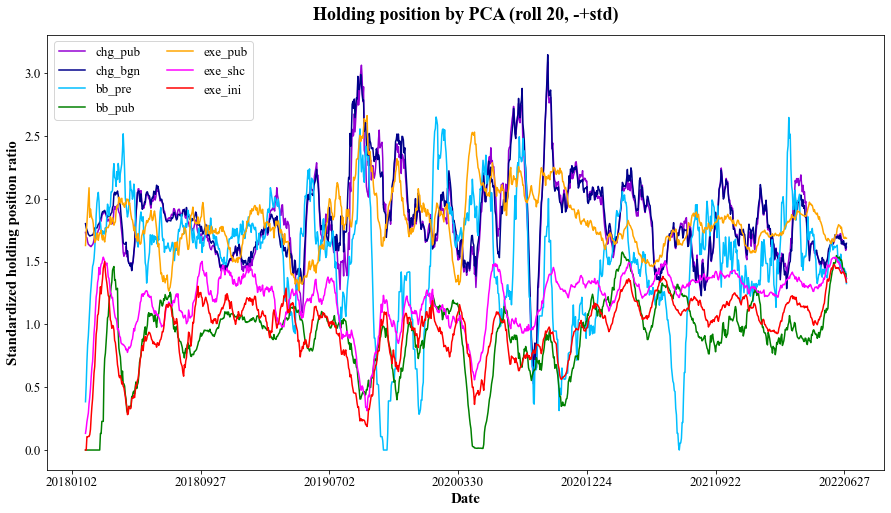

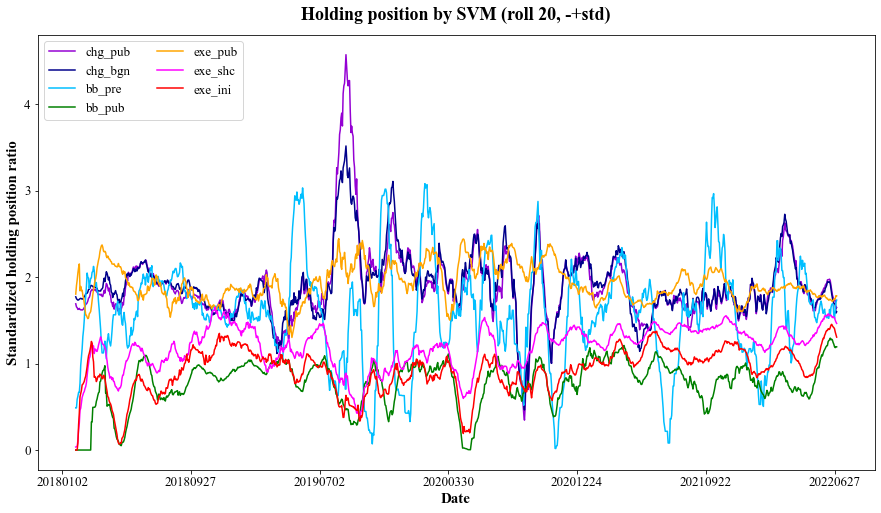

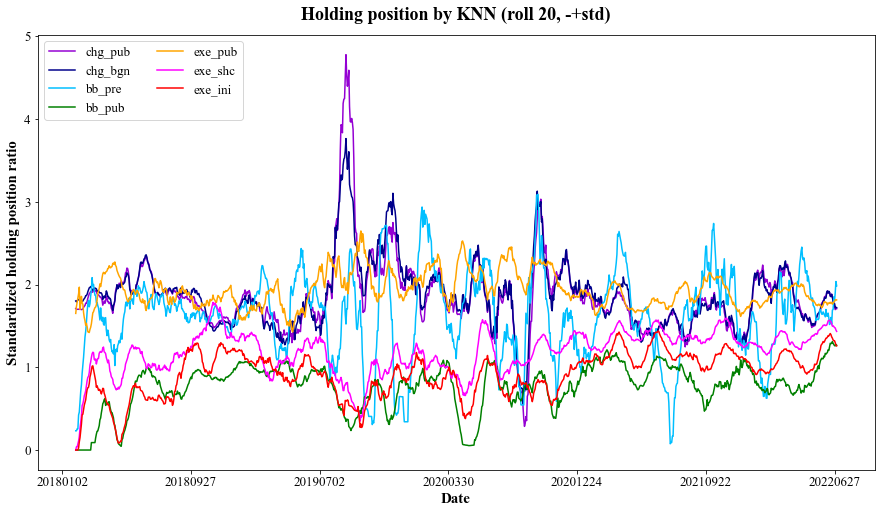

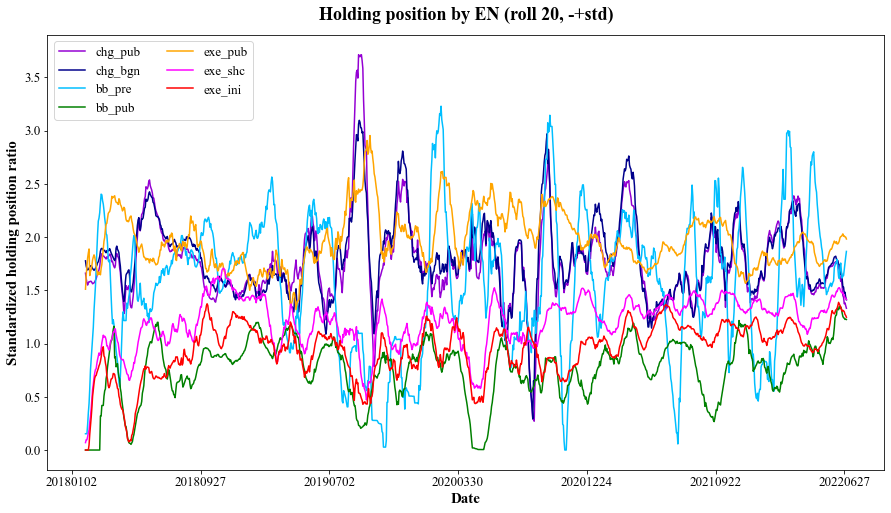

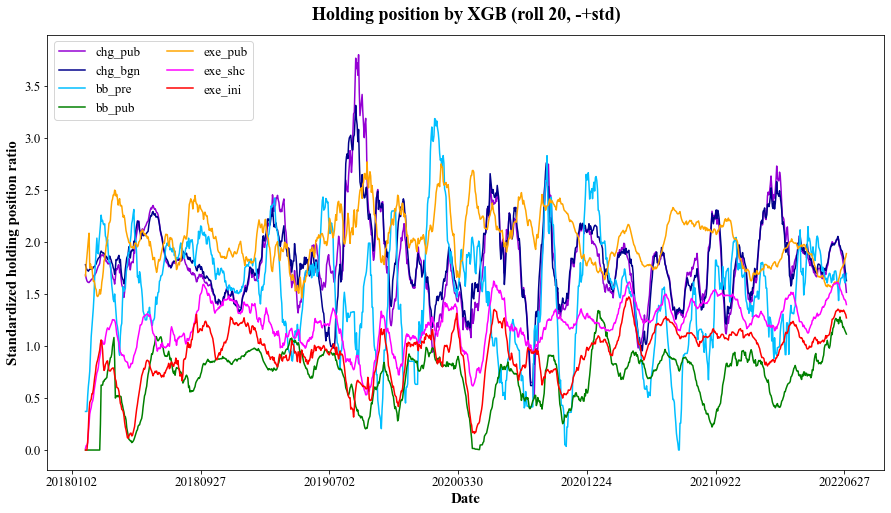

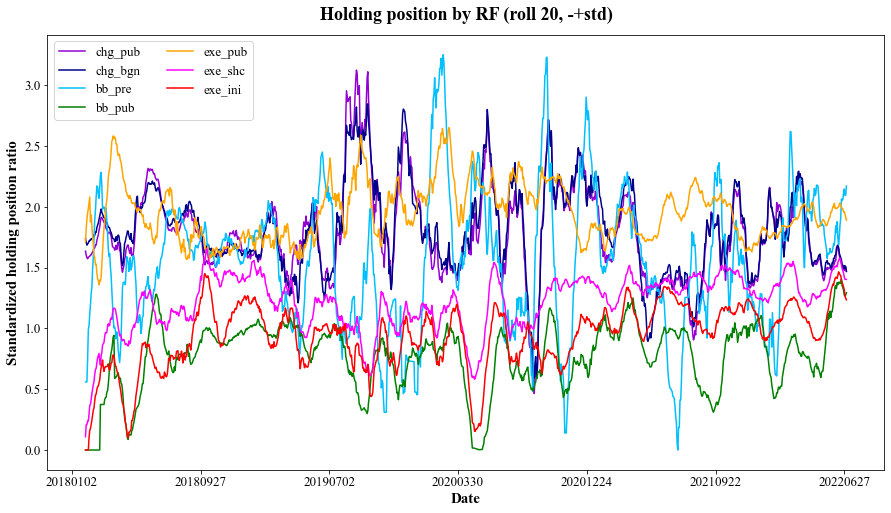

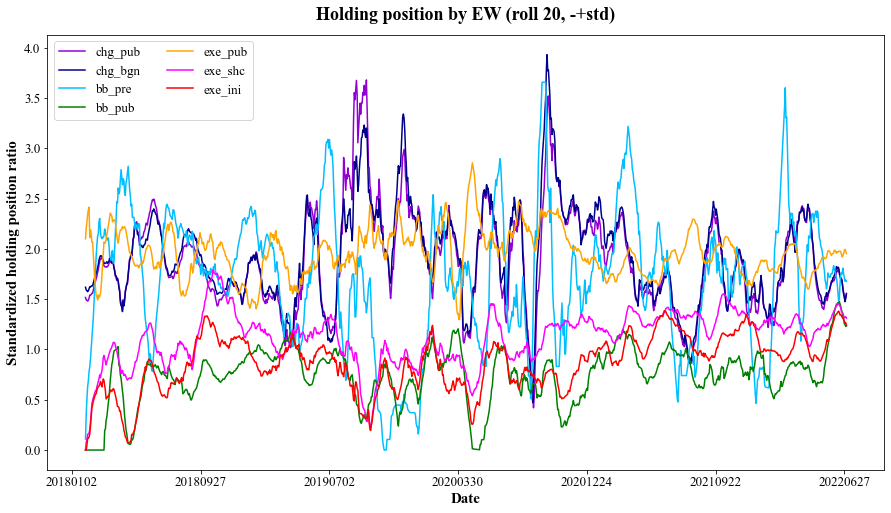

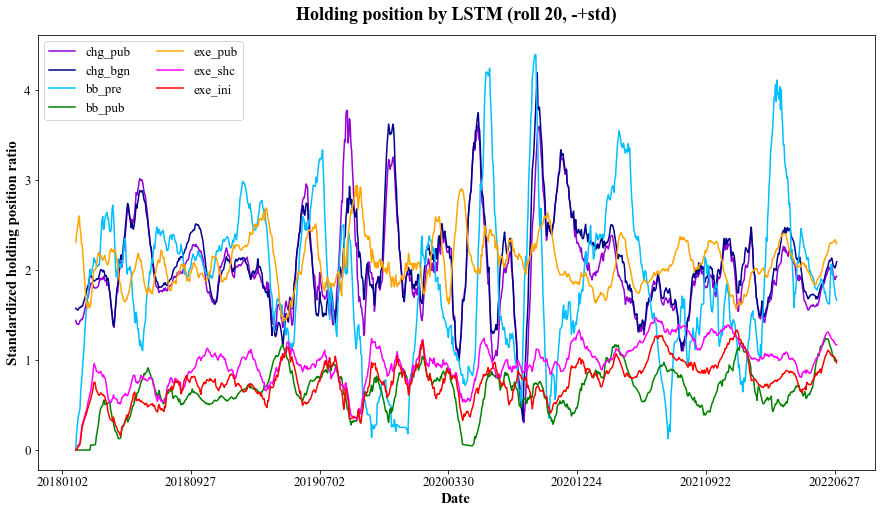

In [906]:
for j in range(0,len(Model_dict)):
    draw_hold(j,list(Model_dict.keys())[j])

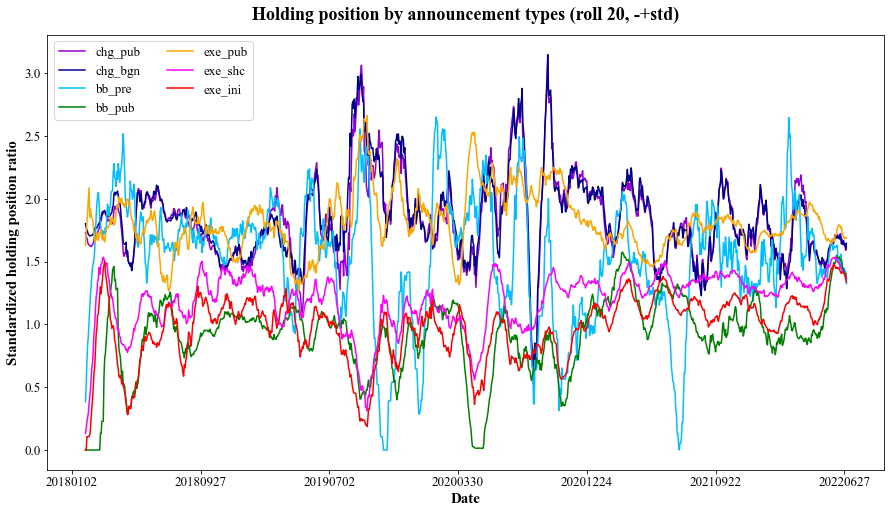

In [899]:
fig = plt.figure(figsize=(15, 8))
j=1
plt.rcParams['font.family'] = 'Times New Roman' #设置字体
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
#ax2 = fig.add_subplot(gs[0, 1])
clrs1=['darkviolet','darkblue','deepskyblue','green','orange','magenta','red']
names = list(total_acc.keys())
for i in range(len(total_acc)):
    mid = (total_acc[names[i]].iloc[:,j].rolling(window=20)).mean()
    ax1.plot(mid,clrs1[i])
    #plt.fill_between(total_acc[names[i]].index,up,down,facecolor = clrs1[i],alpha = 0.2)
ax1.set_xticks(total_acc[names[i]].index[::int(len(list(total_acc[names[i]].index))/6)])
names = ['chg_pub', 'chg_bgn', 'bb_pre', 'bb_pub', 'exe_pub', 'exe_shc', 'exe_ini']
ax1.legend(names,loc = 'upper left',ncol = 2,fontsize=13)

plt.title('Holding position by announcement types (roll 20, -+std)',fontsize=18,pad=15,fontproperties='Times New Roman',fontweight=600)
plt.yticks(fontproperties='Times New Roman', size=13)
plt.xticks(fontproperties='Times New Roman', size=13)
plt.xlabel('Date',fontsize=15,fontweight=600)
plt.ylabel('Standardized holding position ratio',fontsize=15,fontweight=600)
plt.show()
#ax1.set_title('Culmulative feature importance of {} (-+0.01 std)'.format(title),fontsize=15,pad=10)

In [37]:
OLS_dict.keys()

dict_keys(['pred', 'model', 'weight', 'return'])

In [38]:
#求收益率，返回三个，一个是Index，一个是Raw，一个是交易成本
def cal_rtn(OLS_dict,Index_ret):
    date_list = list(OLS_dict['pred'].keys())
    Index_ret_part = Index_ret.iloc[list(Index_ret.index).index(date_list[0]):list(Index_ret.index).index(date_list[-1])+1]
    a = pd.concat([OLS_dict['weight'][i] for i in OLS_dict['weight'].keys()],axis=0)
    tovr_fee = np.array((a.T.fillna(0).diff(axis=1).abs().sum()*0.001/2))
    rtn = np.array(OLS_dict['return'])
    rtn_total = pd.DataFrame(Index_ret_part,columns = ['Index'])
    rtn_total['raw'] = rtn
    rtn_total['tovr'] = tovr_fee

    return rtn_total


In [8]:
OLS_ret = cal_rtn(OLS_dict,Index_ret)

In [108]:
OLS_ret.head(3)

Index       raw      tovr
20180110  0.005409  0.008723  0.000000
20180111 -0.002461 -0.005136  0.000643
20180112 -0.007038 -0.008841  0.000784